# Home Credit Default Risk

    In this project, we aim to develop a machine learning model to predict the likelihood of a customer defaulting on a home credit loan. This is a classification problem where the target variable is binary, indicating whether the customer will default (1) or not (0).

    This notebook is the initial notebook for discovering and exploring data, some cleaning and imputing were done here after reading the HomeCredit_columns_description carefully.

## Install Packages

In [2]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn
! pip install missforest
! pip install tqdm
! pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.0 MB/s eta 0:00:00


## Define Functions

In [1]:
def explore(x):
    """
    This function takes a dataframe as an input and
    return shape and info about the columns in the dataframe.

    Args:
    x (dataframe): The input dataframe to be explored.
    """
    print(x.info(), '\n\nShape:', x.shape)

In [2]:
def nulls_percentage(x):
    """
    This function returns the nulls total count for each column
    and it's percentage

    Args:
        x (dataframe): The input dataframe to calculate nulls count for each column.

    Returns:
        dataframe: nulls count and percentage for each column in the input dataframe.

    Example:
    * nulls_percentage(df)

    .
    """
    y = x.isnull().sum().sort_values(ascending=False)
    y = y.to_frame(name='Missing_Values')
    y['Percentage %'] = y['Missing_Values']/x.shape[0]*100
    return y

In [3]:
def nulls_drop(data, x):
    """
    This function drops the columns with null values greater than x percentage.

    Args:
        data (dataframe): The input dataframe.
        x (float): The threshold value (the null percentage value in decimal of which you want to drop null percentages above).

    Returns:
        data (dataframe): Cleaned dataframe (after dropping columns having a null percentage above the desired threshold value).

    Example:
    * nulls_drop(df , 0.7)   ---> drop columns with nulls percentage above 70%.

    .
    """

    # calculate the threshold number of non-null values needed (x% of the column values)
    threshold = int((1-x) * data.shape[0])
    # drop columns above certain threshold
    data.dropna(axis=1, thresh=threshold, inplace= True)
    # show the cleaned dataframe
    return data

In [4]:
def repeat_percentage(data, x=''):
    """
    This function determines the percentage of occurrence for each unique value within a specific column.

    Args:
        data (dataframe): The input dataframe.
        x (str): The specific column name you want to check repeated values in it. Defaults to ''.

    Returns:
        Pandas Series: Pandas series indicating the percentage of occurrence for each unique value within a specific column.

    Example:
    * repeat_percentage(df , 'NAME_CONTRACT_TYPE')

    .
    """
    return (data[x].value_counts()*100)/data.shape[0]

In [5]:
def correlation(data, x=[], y=''):
    """
    This function calculates the correlation between numerical variables (features) in a dataset.

    Args:
        data (dataframe): The input dataframe.
        x (list): The list of columns you want to measure the correlation between. Defaults to [].
        y (str): The target column in which you want to measure correlation within (must exist in the x list also). Defaults to ''.

    Returns:
        dataframe: A dataframe containing the percentage of correlation, indicating whether it is a negative or positive correlation. (from -1 to 1).

    Example:
    * correlation(df , [ 'EXT_SOURCE_3' , 'EXT_SOURCE_2' , 'EXT_SOURCE_1' , 'TARGET' ] , 'TARGET')

    .
    """
    return data.loc[:,x].corr().sort_values(by= y, axis=0, ascending=False)


In [6]:
def relation(data, x='', y=None):
  """
  This function evaluates the relation between a value or a class in a specific column with the different classes in the "TARGET" column for analysis purpose.


  Args:
      data (dataframe): The input dataframe.
      x (str): The desired column (feature). Defaults to ''.
      y (str, int or float): The desired value you want to evaluate with the target column whether it is a string, integer or a float. Defaults to None.

  Example:
   * relation(df, x='feature1', y=1)

   * relation(df_application_train, x='ORGANIZATION_TYPE', y='Postal')

  .
  """
  print('relation between ' , y , ' and TARGET\n' ,data[data[x] == y]["TARGET"].value_counts(normalize=True),'\n')

In [7]:
def corr_heatmap(data, threshold):
  """
  This function takes your numerical dataframe as an input, and plot a correlation heatmap figure for analysis purposes.


  Args:
      data (dataframe): The input dataframe (must contain numerical features only).
      threshold (float): enter the threshold value and tune it as needed.

  Example:
      corr_heatmap(data= df, threshold= 0.5)


  .
  """
  # create correlation matrix with abs values
  corr_matrix = data.corr().abs()
  # filter the matrix due to threshold value
  filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)]

  plt.figure(figsize=(18,10))
  sns.heatmap(filtered_corr_df, annot=True, cmap="Reds")
  plt.show()

## Define Paths

In [8]:
# Application_train table path
APPLICATION_TRAIN_DATA_PATH = '../data/raw/application_train.csv'

# Interim data directory
INTERIM_DIR = '../data/interim'

## 0. Import Packages

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from missforest import MissForest

import warnings
warnings.filterwarnings('ignore')

In [10]:
pd.set_option('display.max_rows', None)

## 1. Load Data

In [11]:
df = pd.read_csv(APPLICATION_TRAIN_DATA_PATH)

## 2. Explore Data

In [12]:
# Explore data info and shape
explore(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None 

Shape: (307511, 122)


In [13]:
df.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [15]:
df.duplicated().value_counts()

False    307511
Name: count, dtype: int64

In [16]:
nulls_percentage(df)

,Missing_Values,Percentage %
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


In [17]:
df["CNT_FAM_MEMBERS"].value_counts()

CNT_FAM_MEMBERS
2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: count, dtype: int64

In [18]:
df["FLAG_OWN_CAR"].value_counts()

FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

In [19]:
df['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

In [20]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

In [21]:
df['FLAG_OWN_CAR'].value_counts()

FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

In [22]:
df[(df['OWN_CAR_AGE'].isna()) & (df["FLAG_OWN_CAR"] == 'Y')]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
30897,135867,0,Cash loans,M,Y,N,1,495000.0,1006920.0,45630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
181231,310040,0,Cash loans,F,Y,N,0,112500.0,301464.0,22068.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,5.0
217549,352070,0,Cash loans,M,Y,N,0,225000.0,900000.0,26446.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0
229867,366246,0,Cash loans,F,Y,Y,1,225000.0,518562.0,25078.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
236868,374361,0,Cash loans,F,Y,Y,0,225000.0,233833.5,26577.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0


In [23]:
relation(df, 'CODE_GENDER', 'XNA')
relation(df, 'CODE_GENDER', 'F')
relation(df, 'CODE_GENDER', 'M')

relation between  XNA  and TARGET
 TARGET
0    1.0
Name: proportion, dtype: float64 

relation between  F  and TARGET
 TARGET
0    0.930007
1    0.069993
Name: proportion, dtype: float64 

relation between  M  and TARGET
 TARGET
0    0.898581
1    0.101419
Name: proportion, dtype: float64 



In [24]:
relation(df, 'OCCUPATION_TYPE', 'Laborers')
relation(df, 'OCCUPATION_TYPE', 'Cleaning staff')
relation(df, 'OCCUPATION_TYPE', 'Managers')

relation between  Laborers  and TARGET
 TARGET
0    0.894212
1    0.105788
Name: proportion, dtype: float64 

relation between  Cleaning staff  and TARGET
 TARGET
0    0.903933
1    0.096067
Name: proportion, dtype: float64 

relation between  Managers  and TARGET
 TARGET
0    0.93786
1    0.06214
Name: proportion, dtype: float64 



In [25]:
# calculate the correlation between numerical columns
correlation(df, ['EXT_SOURCE_3', 'EXT_SOURCE_2','EXT_SOURCE_1', 'AMT_GOODS_PRICE', 'TARGET'], 'TARGET')

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,AMT_GOODS_PRICE,TARGET
TARGET,-0.178919,-0.160472,-0.155317,-0.039645,1.000000
AMT_GOODS_PRICE,0.047717,0.139367,0.175502,1.000000,-0.039645
EXT_SOURCE_1,0.186846,0.213982,1.000000,0.175502,-0.155317
EXT_SOURCE_2,0.109167,1.000000,0.213982,0.139367,-0.160472
EXT_SOURCE_3,1.000000,0.109167,0.186846,0.047717,-0.178919


In [26]:
correlation(df, ['CNT_CHILDREN', 'CNT_FAM_MEMBERS'], 'CNT_FAM_MEMBERS')

,CNT_CHILDREN,CNT_FAM_MEMBERS
CNT_FAM_MEMBERS,0.879161,1.000000
CNT_CHILDREN,1.000000,0.879161


In [27]:
df['DAYS_EMPLOYED'].value_counts()

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
-212         150
-384         143
-229         143
-231         140
-215         138
-207         138
-216         137
-188         137
-196         136
-116         136
-222         135
-193         134
-195         133
-214         132
-254         131
-213         131
-201         130
-381         130
-233         128
-185         128
-194         127
-237         127
-184         126
-234         126
-209         125
-348         125
-241         124
-745         123
-137         123
-382         122
-139         122
-198         122
-238         122
-218         120
-240         120
-205         120
-191         120
-118         119
-223         119
-225         119
-181         118
-430         118
-244         118
-227         118
-268         117
-370         117
-133         117
-132         117
-228         117
-115         117
-119         116
-204         116
-129         116


In [28]:
# a noise value was detected in the 'DAYS_EMPLOYED' column

# relation between the noise value and the target
df[df['DAYS_EMPLOYED'] > 365000]["TARGET"].value_counts(normalize=True)

TARGET
0    0.946004
1    0.053996
Name: proportion, dtype: float64

In [29]:
df[df['FLAG_CONT_MOBILE'] == 1]["TARGET"].value_counts(normalize=True)

TARGET
0    0.919267
1    0.080733
Name: proportion, dtype: float64

In [30]:
df[df['FLAG_CONT_MOBILE'] == 0]["TARGET"].value_counts(normalize=True)

TARGET
0    0.921603
1    0.078397
Name: proportion, dtype: float64

## 3. Preprocess Data

In [33]:
# remove the four rows with 'XNA' gender due to insufficient data and imbalance
df = df[(df['CODE_GENDER'] == 'F') | (df["CODE_GENDER"] == 'M')]
df['CODE_GENDER'].value_counts()

,count
CODE_GENDER,
F,202448
M,105059


In [34]:
# Select candidate columns that contain meaningful data and drop others
cleaned_df = df.loc[:, ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
                    'FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                    'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
                    'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                    'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                    'OWN_CAR_AGE','OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'ORGANIZATION_TYPE',
                    'EXT_SOURCE_2', 'EXT_SOURCE_3', 'LIVINGAREA_AVG','TOTALAREA_MODE',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
                    'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','FLAG_MOBIL',
                    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE','FLAG_EMAIL',
                    'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
                    'LIVE_REGION_NOT_WORK_REGION','DAYS_LAST_PHONE_CHANGE'
                  ]
              ]

In [35]:
# split the dataframe into numerical data and categorical data
cat = cleaned_df.select_dtypes('object')
num = cleaned_df.select_dtypes(include=['int64','float64'])
print(cat.shape, '\n', num.shape)

(307507, 10) 
 (307507, 35)


In [36]:
# Rename specific columns related to number of days
num = num.rename(columns={"DAYS_BIRTH": "YEARS_BIRTH",'DAYS_EMPLOYED':'YEARS_EMPLOYED','DAYS_REGISTRATION':'YEARS_REGISTRATION','DAYS_ID_PUBLISH':'YEARS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE':'YEARS_LAST_PHONE_CHANGE'})

# Calculate the number of years for each column in days
num['YEARS_BIRTH'] = num['YEARS_BIRTH'].abs()/365
num['YEARS_EMPLOYED'] = num['YEARS_EMPLOYED'].abs()/365
num['YEARS_REGISTRATION'] = num['YEARS_REGISTRATION'].abs()/365
num['YEARS_ID_PUBLISH'] = num['YEARS_ID_PUBLISH'].abs()/365
num['YEARS_LAST_PHONE_CHANGE'] = num['YEARS_LAST_PHONE_CHANGE'].abs()/365
num.head(10)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,YEARS_BIRTH,YEARS_EMPLOYED,...,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,YEARS_LAST_PHONE_CHANGE
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,1.745205,...,1,0,1,0,2,2,0,0,0,3.106849
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,3.254795,...,1,0,1,0,1,1,0,0,0,2.268493
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,0.616438,...,1,1,1,0,2,2,0,0,0,2.232877
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,8.326027,...,1,0,1,0,2,2,0,0,0,1.690411
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,8.323288,...,1,0,1,0,2,2,0,0,0,3.030137
5,100008,0,0,99000.0,490495.5,27517.5,454500.0,0.035792,46.413699,4.350685,...,1,1,1,0,2,2,0,0,0,6.947945
6,100009,0,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,37.747945,8.575342,...,1,0,1,0,2,2,0,0,0,4.279452
7,100010,0,0,360000.0,1530000.0,42075.0,1530000.0,0.003122,51.643836,1.230137,...,1,1,1,0,3,3,0,0,0,2.931507
8,100011,0,0,112500.0,1019610.0,33826.5,913500.0,0.018634,55.065753,1000.665753,...,0,0,1,0,2,2,0,0,0,0.000000
9,100012,0,0,135000.0,405000.0,20250.0,405000.0,0.019689,39.641096,5.531507,...,1,0,1,0,2,2,0,0,0,4.583562


### 3.1 Exploring Features Histograms

array([[<Axes: title={'center': 'YEARS_LAST_PHONE_CHANGE'}>]],
      dtype=object)

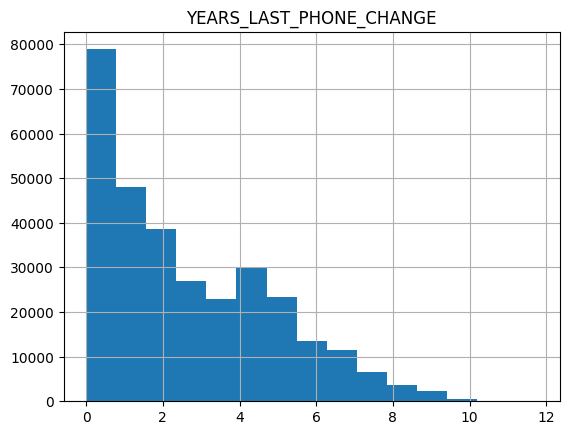

In [37]:
# show the distribution of "YEARS_LAST_PHONE_CHANGE" column by using the histogram plot
pd.DataFrame.hist(num, column='YEARS_LAST_PHONE_CHANGE', bins= 15)

In [38]:
num[num['YEARS_LAST_PHONE_CHANGE'] < 4]["TARGET"].value_counts(normalize=True)

,proportion
TARGET,
0,0.910684
1,0.089316


In [39]:
explore(num)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307507 non-null  int64  
 1   TARGET                       307507 non-null  int64  
 2   CNT_CHILDREN                 307507 non-null  int64  
 3   AMT_INCOME_TOTAL             307507 non-null  float64
 4   AMT_CREDIT                   307507 non-null  float64
 5   AMT_ANNUITY                  307495 non-null  float64
 6   AMT_GOODS_PRICE              307229 non-null  float64
 7   REGION_POPULATION_RELATIVE   307507 non-null  float64
 8   YEARS_BIRTH                  307507 non-null  float64
 9   YEARS_EMPLOYED               307507 non-null  float64
 10  OWN_CAR_AGE                  104580 non-null  float64
 11  CNT_FAM_MEMBERS              307505 non-null  float64
 12  EXT_SOURCE_2                 306847 non-null  float64
 13  EXT_

array([[<Axes: title={'center': 'YEARS_BIRTH'}>]], dtype=object)

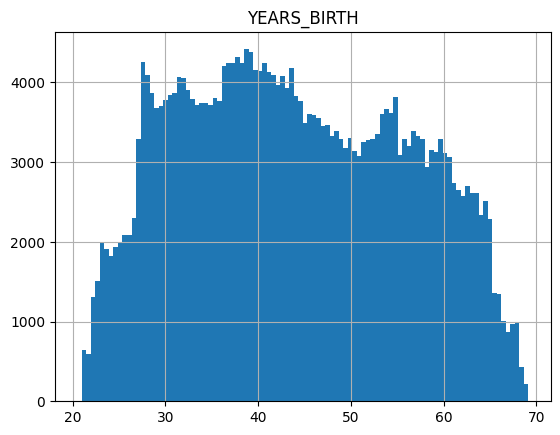

In [40]:
pd.DataFrame.hist(num, column='YEARS_BIRTH', bins= 100)

array([[<Axes: title={'center': 'AMT_REQ_CREDIT_BUREAU_YEAR'}>]],
      dtype=object)

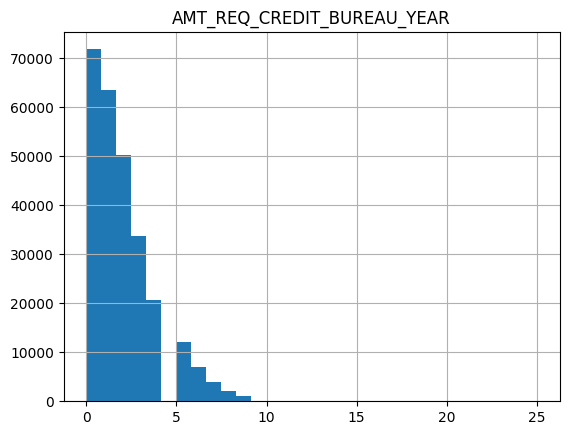

In [41]:
pd.DataFrame.hist(num, column='AMT_REQ_CREDIT_BUREAU_YEAR', bins= 30)

array([[<Axes: title={'center': 'OWN_CAR_AGE'}>]], dtype=object)

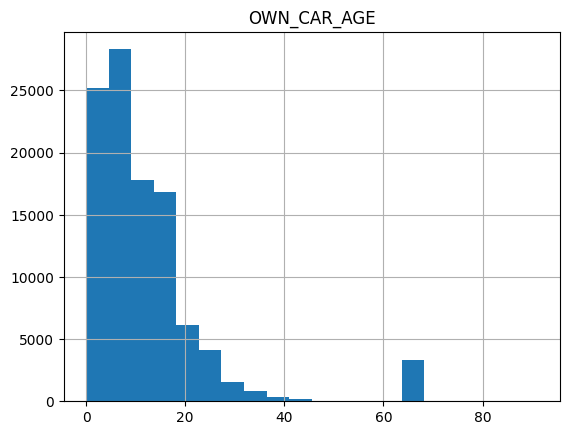

In [42]:
pd.DataFrame.hist(num, column='OWN_CAR_AGE', bins= 20)

In [43]:
num[['OWN_CAR_AGE']].mode()

,OWN_CAR_AGE
0,7.0


In [44]:
# find skewness of data to perform best imputation technique for each column
pd.options.display.max_rows = 30
num.skew()

,0
SK_ID_CURR,-0.001213
TARGET,3.078133
CNT_CHILDREN,1.974634
AMT_INCOME_TOTAL,391.557413
AMT_CREDIT,1.234761
...,...
REGION_RATING_CLIENT_W_CITY,0.059724
REG_REGION_NOT_LIVE_REGION,7.940222
REG_REGION_NOT_WORK_REGION,4.092736
LIVE_REGION_NOT_WORK_REGION,4.651586


### 3.2 Exploring Correlations

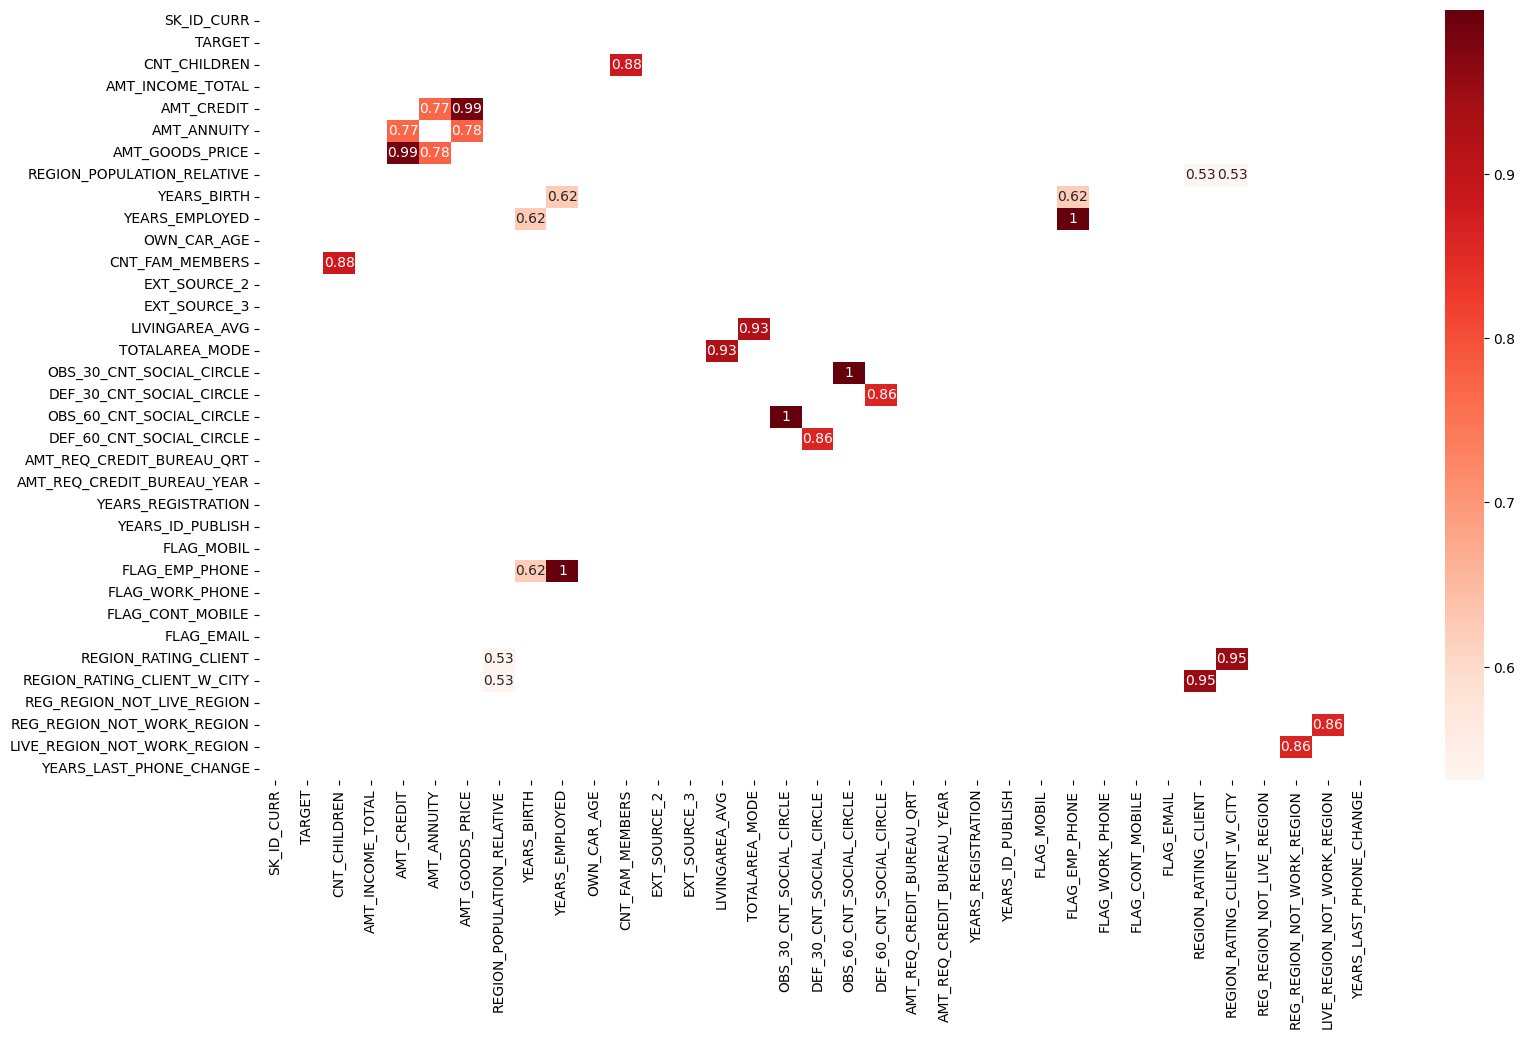

In [45]:
corr_heatmap(num, 0.5)

### 3.3 Cleaning Data

In [46]:
# Change the noise values to the median, as the current values are nonsensical.
num["YEARS_EMPLOYED"][num["YEARS_EMPLOYED"]>1000] = num["YEARS_EMPLOYED"].median()
num['YEARS_EMPLOYED'].tail(10)

,YEARS_EMPLOYED
307501,2.865753
307502,23.934247
307503,1.093151
307504,19.884932
307505,6.079452
307506,0.646575
307507,6.079452
307508,21.701370
307509,13.112329
307510,3.457534


In [47]:
# Dropping unnecessary columns
num.drop(['AMT_REQ_CREDIT_BUREAU_QRT','FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'YEARS_LAST_PHONE_CHANGE'], axis=1, inplace=True)

In [48]:
# Fill five missing values of 'OWN_CAR_AGE' column with the mode value
num[(num['OWN_CAR_AGE'].isna()) & (cat["FLAG_OWN_CAR"] == 'Y')] = num[(num['OWN_CAR_AGE'].isna()) & (cat["FLAG_OWN_CAR"] == 'Y')].fillna(7)

In [49]:
# fill nulls with median for specific columns based on observations and null percentages
'''
    ['DEF_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE','AMT_ANNUITY']
'''

num[['DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_REQ_CREDIT_BUREAU_YEAR']] = num[['DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_REQ_CREDIT_BUREAU_YEAR']].fillna(num[['DEF_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE','AMT_ANNUITY','AMT_REQ_CREDIT_BUREAU_YEAR']].median())

In [50]:
mf = MissForest(rgr=RandomForestRegressor())
num_imputed = mf.fit_transform(num[['LIVINGAREA_AVG', 'TOTALAREA_MODE', 'EXT_SOURCE_3']])

100%|██████████| 5/5 [00:31<00:00,  6.26s/it]


In [51]:
# Update num dataframe with the imputed values using the RandomForestAlgorithm
num[['LIVINGAREA_AVG']] = num_imputed[['LIVINGAREA_AVG']]
num[['TOTALAREA_MODE']] = num_imputed[['TOTALAREA_MODE']]
num[['EXT_SOURCE_3']] = num_imputed[['EXT_SOURCE_3']]
num[['LIVINGAREA_AVG', 'TOTALAREA_MODE', 'EXT_SOURCE_3']].head(5)

,LIVINGAREA_AVG,TOTALAREA_MODE,EXT_SOURCE_3
0,0.0190,0.014900,0.139376
1,0.0549,0.071400,0.380093
2,0.0745,0.068557,0.729567
3,0.0745,0.068800,0.451147
4,0.0745,0.068800,0.451147


In [52]:
cat['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace=True)

In [53]:
df_concat = pd.concat([num, cat], axis=1)
explore(df_concat)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307507 non-null  int64  
 1   TARGET                       307507 non-null  int64  
 2   CNT_CHILDREN                 307507 non-null  int64  
 3   AMT_INCOME_TOTAL             307507 non-null  float64
 4   AMT_CREDIT                   307507 non-null  float64
 5   AMT_ANNUITY                  307507 non-null  float64
 6   AMT_GOODS_PRICE              307507 non-null  float64
 7   REGION_POPULATION_RELATIVE   307507 non-null  float64
 8   YEARS_BIRTH                  307507 non-null  float64
 9   YEARS_EMPLOYED               307507 non-null  float64
 10  OWN_CAR_AGE                  104585 non-null  float64
 11  CNT_FAM_MEMBERS              307505 non-null  float64
 12  EXT_SOURCE_2                 307507 non-null  float64
 13  EXT_

## 4. Save Data

In [ ]:
# Save a copy of the interim dataframe as a checkpoint
df_concat.to_csv(f'{INTERIM_DIR}/df_last.csv')